**Importing the packages**

In [1]:
#from mpmath import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks

### In here no equation will be displayed

All calculations were made based in the results presented in:  
[**Universal Algorithm for Simulating and Evaluating Cyclic Voltammetry at Macroporous Electrodes by Considering Random Arrays of Microelectrodes**](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cphc.201901113).

**Defining operator to make inverse Laplace Transform**

We need to have this operation well made, so that all the calculations from now onwards are right

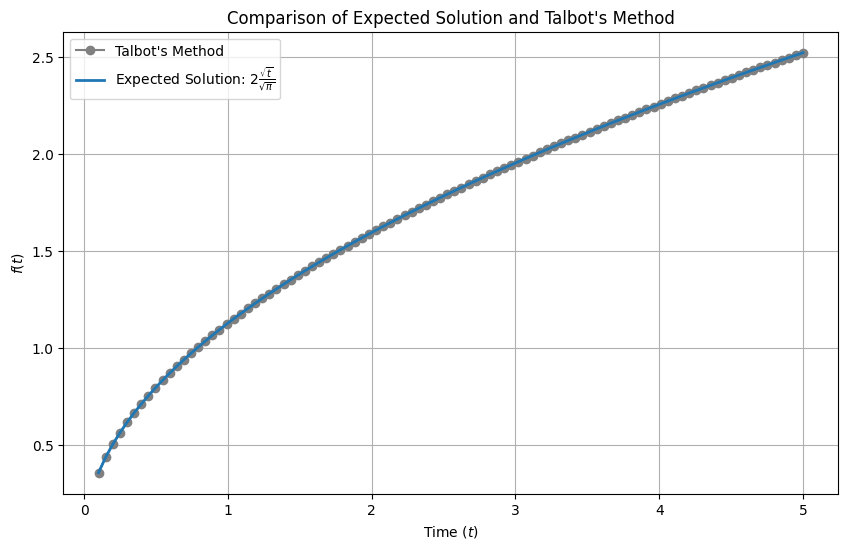

In [2]:
def Talbot(F, t_vals, N=24):
    # https://code.activestate.com/recipes/576934-numerical-inversion-of-the-laplace-transform-using/
    """
    Computes the inverse Laplace transform using Talbot's method for multiple time values.

    Parameters:
        F (callable): Function in the Laplace domain (F(s)).
        t_vals (array-like): Array of time values to evaluate the inverse transform.
        N (int): Number of terms in the summation (higher = better accuracy).

    Returns:
        np.ndarray: Approximated inverse Laplace transform values for all `t_vals`.
    """
    t_vals = np.asarray(t_vals, dtype=np.float64)  # Ensure it's a numpy array
    results = np.zeros_like(t_vals, dtype=np.float64)

    # Step size
    h = 2 * np.pi / N
    shift = 0.0  # Adjust this if needed for poles on the positive real axis

    for idx, t in enumerate(t_vals):
        if t <= 1e-10:
            results[idx] = 0.0  # Assign NaN for invalid t values
            continue

        ans = 0.0
        for k in range(N):
            theta = -np.pi + (k + 0.5) * h  # Midpoint rule
            cot_term = 1 / np.tan(0.6407 * theta)  # Avoid division issues with cotangent

            # Talbot contour transformation
            z = shift + (N / t) * (0.5017 * theta * cot_term - 0.6122 + 0.2645j * theta)
            dz = (N / t) * (-0.5017 * 0.6407 * theta / np.sin(0.6407 * theta) ** 2 + 0.5017 * cot_term + 0.2645j)

            # Debugging: Check for NaN or inf in F(z) or dz
            if np.isnan(F(z)) or np.isinf(F(z)) or np.isnan(dz) or np.isinf(dz):
                print(f"Warning: F(z) or dz is NaN/inf at t = {t}, z = {z}")
                continue

            ans += np.exp(z * t) * F(z) * dz

        results[idx] = (h / (2j * np.pi) * ans).real  # Store the computed value

    return results

# Define the Laplace domain function
def F(s):
    return 1 / (s ** (3/2))  # Laplace transform of f(t) = 2*sqrt(t)/sqrt(pi)

# Define the expected solution
def expected_solution(t):
    return 2 * np.sqrt(t) / np.sqrt(np.pi)

# Time values to evaluate the inverse transform
t_vals = np.linspace(0.1, 5, 100)

# Compute the inverse Laplace transform using Talbot's method
talbot_results = Talbot(F, t_vals)

# Compute the expected solution
expected_results = expected_solution(t_vals)

# Plot the comparison
plt.figure(figsize=(10, 6))

plt.plot(t_vals, talbot_results,"o-" ,color='gray', label="Talbot's Method")
plt.plot(t_vals, expected_results, label="Expected Solution: $2 \\frac{\sqrt{t}}{\sqrt{\pi}}$", linestyle="-", linewidth=2)
plt.xlabel("Time ($t$)")
plt.ylabel("$f(t)$")
plt.title("Comparison of Expected Solution and Talbot's Method")
plt.legend()
plt.grid(True)
plt.show()

**Defining a function that help us build the experimental situation**

In [3]:
def generate_epsilon(scan_rate, E_start, E_peak, num_points):
    """
    Generates a triangular potential waveform for cyclic voltammetry.
    
    scan_rate: Rate of potential change (V/s)
    E_start: Initial potential (V)
    E_peak: Peak potential (V)
    num_points: Total number of points in the scan
    
    Returns:
        t: Time array
        epsilon: Potential array
    """
    # Half the time for forward and backward scans
    num_half = num_points // 2  

    # Time step based on scan rate
    t_up = np.linspace(1e-3, (E_peak - E_start) / scan_rate, num_half)  # Forward scan
    t_down = np.linspace(t_up[-1], 2 * t_up[-1], num_half)           # Reverse scan
    t = np.concatenate((t_up, t_down))  # Full time array

    # Generate potential
    epsilon_up = E_start + scan_rate * t_up  # Forward potential
    epsilon_down = E_peak - scan_rate * (t_down - t_up[-1])  # Reverse potential
    epsilon = np.concatenate((epsilon_up, epsilon_down))  # Full potential

    return t, epsilon


**Defining the Class that does the math for us**

In [4]:
class CVCurrent:
    """   
    This class models the current response in a cyclic voltammetry (CV) experiment, incorporating electrochemical kinetics and diffusion effects.
    It defines key parameters for charge transfer, mass transport, and reaction kinetics, allowing for the calculation of current as a function
    of time and applied potential.

    Attributes:
        Electrode and Reaction Parameters:
            - A (float): Electrode surface area (cm²).
            - F (float): Faraday’s constant (C/mol).
            - R (float): Universal gas constant (J/(mol·K)).
            - T (float): Temperature (K).
            - n (int): Number of electrons transferred in the reaction.
            - c (float): Total concentration of the redox species (mol/cm³).
            - alpha (float): Charge transfer coefficient.
        
        Kinetic and Diffusion Parameters:
            - Kp (float): Ratio of forward (kp) and backward (k_p) reaction rates for a chemical step.
            - Kf (float): Ratio of forward (kf) and backward (k_f) reaction rates for a second chemical step.
            - p (float): Total rate constant for the first chemical reaction (kp + k_p).
            - f (float): Total rate constant for the second chemical reaction (kf + k_f).
            - DO (float): Diffusion coefficient of the oxidized species (cm²/s).
            - DR (float): Diffusion coefficient of the reduced species (cm²/s).
            - km (float): Maximum electron transfer rate constant (1/s).
            - k0 (float): Standard electron transfer rate constant (cm/s).
            - d (float): Characteristic diffusion layer thickness (cm).
    
    Methods:
        - __call__(t, epsilon): Computes the cyclic voltammetry current as a function of time (t) and applied potential (epsilon).
            Uses cubic spline interpolation to evaluate two functions (FuncG and FuncY) over a logarithmic time grid.
            Implements a recursive approach to compute current, incorporating both electron transfer and chemical kinetics.
            The current response is influenced by mass transport effects, reaction kinetics, and charge transfer rates.
        
        - FuncG(t): Placeholder method (to be implemented) for calculating a time-dependent function related to the system dynamics.
        
        - FuncY(t): Placeholder method (to be implemented) for another time-dependent function required for current calculations.
    """


    def __init__(self,kmax = 1e10,c_tot = 0.16,kp = 0.0028,k_p = 0.0015,kf = 0.0008,k_f = 0.0003 ,DO = 3.2e-5,DR =2.7e-5 ,k0 = 2.6*10**(-4), alpha = 0.42 ,A = 28e-4 , F = 96485.3321 , R = 8.314 ,T = 298.15 ,n = 1,d = 0.5 ):
        self.A = A
        self.F = F
        self.R = R
        self.T = T
        self.n = n
        self.c = c_tot
        self.alpha = alpha
        self.Kp = kp/k_p
        self.Kf = kf/k_f
        self.p = kp + k_p
        self.f = kf+k_f
        self.DO = DO
        self.DR = DR
        self.km = kmax
        self.k0 = k0
        self.d = d

    def __call__(self,t,epsilon):
        I = []
        delta = t[1]-t[0]

         # Generate logarithmic time grid for G and Y
        t_log = np.logspace(-5, 5, 300)  # 300 points from 10^-5 to 10^5
        G_log = self.FuncG(t_log)
        Y_log = self.FuncY(t_log)

        # Create cubic spline interpolators
        G_spline = CubicSpline(t_log, G_log)
        Y_spline = CubicSpline(t_log, Y_log)

        # Interpolate at the desired time points
        G = G_spline(t)
        Y = Y_spline(t)      

        for i in range(len(t)):

            term1 = self.km/(self.km + self.k0*np.exp(self.alpha*epsilon[i]))*1/(1+self.Kp) 
            term11 = np.sqrt(self.DR)/self.k0 * np.exp(-self.alpha*epsilon[i]) + (self.km)/(self.km+self.k0*np.exp(self.alpha*epsilon[i]))*G[1] + (self.km)/(self.km + self.k0*np.exp(-(1-self.alpha)*epsilon[i]))*np.sqrt(self.DR/self.DO) * Y[1]*np.exp(-epsilon[i])
            I1 = (self.n*self.F*self.A * self.c * self.Kp * np.sqrt(self.DR))

            term2 = -self.km/(self.km + self.k0*np.exp(-(1-self.alpha)*epsilon[i]))*np.exp(-epsilon[i])/(1+self.Kf) * (np.sqrt(self.DR/self.DO))
            I2 = 0
            for j in range(1,i-1):
                dY = Y[i-j+1] - Y[i-j]
                dG = G[i-j+1] - G[i-j]
                I1 -= I[j]*dG*(self.Kp + np.exp( -delta*self.p*(i-j)))
                I2 += I[j]*dY*(1 + self.Kf * np.exp(-delta*self.f*(i-j)))

            I.append(I1*term1/term11 + term2/term11 * I2)

        return np.array(I)
    
    def FuncG(t):

        raise NotImplemented
    
    def FuncY(t):

        raise NotImplemented    

In [5]:
class Planar_Semi_Inf(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):

        GLaplace = lambda s: 1/np.sqrt(s)*(1/s)

        return Talbot(GLaplace, t , N=24)
    
    def FuncY(self,t):

        YLaplace = lambda s: 1/np.sqrt(s)*(1/s)

        Y =  Talbot(YLaplace, t , N=24)

        return Y

**Let's First try to calculate something we know**

Which is the $\chi$ used in the Randle-Sevick Equation to define the peak of reduction and oxidation current

In [28]:
# Simulating CV Data
c = 0.16
A = 28e-4
F = 96485.3321
R = 8.34
T = 298.15
n = 1
D = 2.7*10**(-5-4)
cv = Planar_Semi_Inf(c_tot = c, A = A , F = F, R = R,DR = D,DO = D , T = T, n =n )

scan_rate = 10

t = np.linspace(1e-2,10,50)
epsilon = -10 + scan_rate*t
# Compute current response
I = cv(t, epsilon)

t2 = np.linspace(1e-2,10,500)
epsilon2 = -10 + scan_rate*t2
I2 = cv(t2, epsilon2)

t3 = np.linspace(1e-2,10,1000)
epsilon3 = -10 + scan_rate*t3
I3 = cv(t3, epsilon3)

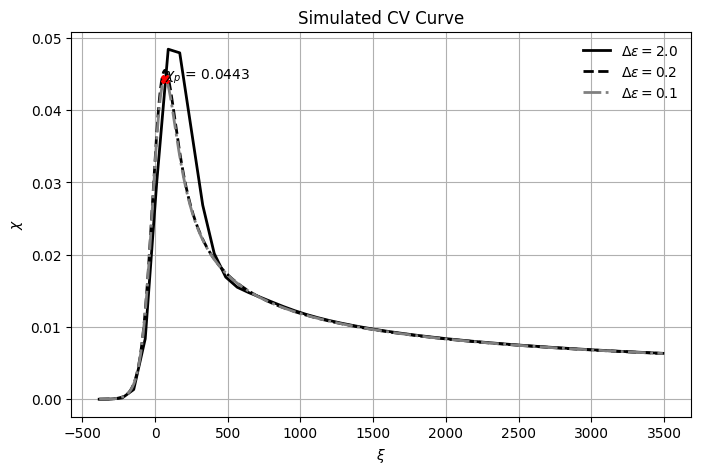

In [33]:
# Plot CV Graph

plt.figure(figsize=(8, 5))
plt.plot(epsilon*n*F/(R*T), I / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)), '-',color='black', linewidth=2 , label = f'$\Delta \epsilon = {round(epsilon[2]-epsilon[1],1)}$')
plt.plot(epsilon2*n*F/(R*T), I2 / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)), '--',color='black', linewidth=2, label = f'$\Delta \epsilon = {round(epsilon2[2]-epsilon2[1],2)}$')
plt.plot(epsilon3*n*F/(R*T) , I3 / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)), '-.',color='gray', linewidth=2, label = f'$\Delta \epsilon = {round(epsilon3[2]-epsilon3[1],3)}$')

peaks,_ = find_peaks(I3)

plt.plot(epsilon3[peaks[-1]]*n*F/(R*T) , I3[peaks[-1]] / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)),'X',color='red')

xp = I3[peaks][-1]
yp = epsilon3[peaks][-1]
plt.annotate(f'$\\chi_p$ = {np.round(xp / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate)),4)}',xy = (0,0),
             xytext=(yp*n*F/(R*T) + 0.1 ,xp / (n*F*A*c) * np.sqrt(R*T/(n*F*D*scan_rate))))

plt.xlabel("$\\xi $")
plt.ylabel("$\chi$")
plt.title("Simulated CV Curve")
plt.grid(True)
plt.legend(frameon=False)

plt.show()


**Know apply it to real system**

To do it we need to have a finite electrode, so we need to define it

In [8]:
class Planar_Finite(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):

        GLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DR) ) / (np.sinh(self.d * np.sqrt(s/self.DR) ) ) )/np.sqrt(s)*(1/s)

        return Talbot(GLaplace, t , N=16)
    
    def FuncY(self,t):

        YLaplace = lambda s: (np.cosh(self.d * np.sqrt(s/self.DO) ) / (np.sinh(self.d * np.sqrt(s/self.DO) )  ) )/np.sqrt(s)*(1/s)

        Y =  Talbot(YLaplace, t , N=16)

        return Y

Define a new situation

Text(0.5, 1.0, 'Curve the Potential will do')

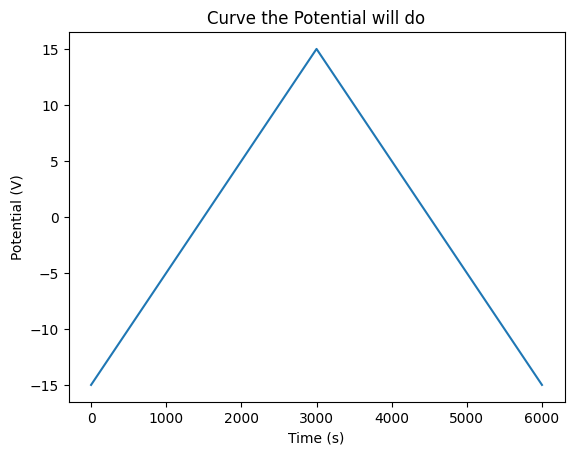

In [9]:
scan_rate = 10e-3  # Scan Rate (V/s)
E_start = -15   # Initial potential (V)
E_peak = 15    # Peak potential (V)
num_points = 500  # Number of time steps

t, epsilon = generate_epsilon(scan_rate, E_start, E_peak, num_points)

plt.plot(t,epsilon)
plt.xlabel("Time (s)")
plt.ylabel("Potential (V)")
plt.title("Curve the Potential will do")

Simulate

In [ ]:
c = 0.1 #mol/L
A = 1e-4 #cm^2
DR = 1e-10 #cm^2/s
DO = 1e-10 #cm^2/s
k0 = 1e-5 #cm^2/s
alpha = 0.5
kp = 1e-4#1e-4
k_p = 1e-4#kp/2
kf = 1e-4#1e-4
k_f = 1e-4#kf
km = 1e3

In [150]:
fp = Planar_Finite(d=50e-6,c_tot=c,A=A,DR=DR,DO=DO,k0=k0,alpha=alpha,kp=kp,k_p=k_p,k_f=k_f,kf=kf,kmax=km)
I = fp(t, epsilon)

Show Simulation

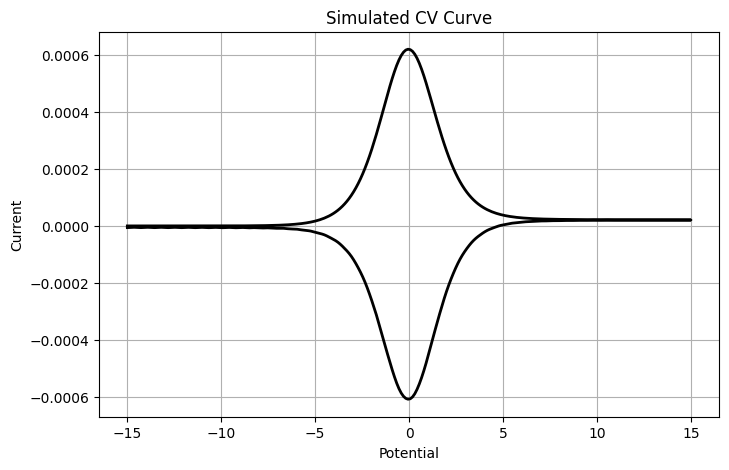

In [151]:
plt.figure(figsize=(8, 5))
plt.plot(epsilon, I , '-',color='black', linewidth=2)
plt.xlabel("Potential")
plt.ylabel("Current")
plt.title("Simulated CV Curve")
plt.grid(True)


plt.show()


A lot more can be implemented, specially to define the case of an electrode with a sphere like geometry, allowing a good approximation to the expected when we have nanoparticles

In [113]:
class Sphere_Finite(CVCurrent):

    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def FuncG(self,t):

        GLaplace = lambda s: 1/(np.cosh(self.d * np.sqrt(s/self.DR) )/ (np.sinh(self.d * np.sqrt(s/self.DR) ) + 1e-10 )  * np.sqrt(s) - np.sqrt(self.DR)/self.d )*(1/s)

        return Talbot(GLaplace, t , N=16)
    
    def FuncY(self,t):

        YLaplace = lambda s: 1/(np.cosh(self.d * np.sqrt(s/self.DO) )/ (np.sinh(self.d * np.sqrt(s/self.DO) ) + 1e-10 )  * np.sqrt(s) - np.sqrt(self.DO)/self.d )*(1/s)

        Y =  Talbot(YLaplace, t , N=16)

        return Y

In [117]:
fe = Sphere_Finite(d=5e-6)
Ie = fe(t, epsilon)

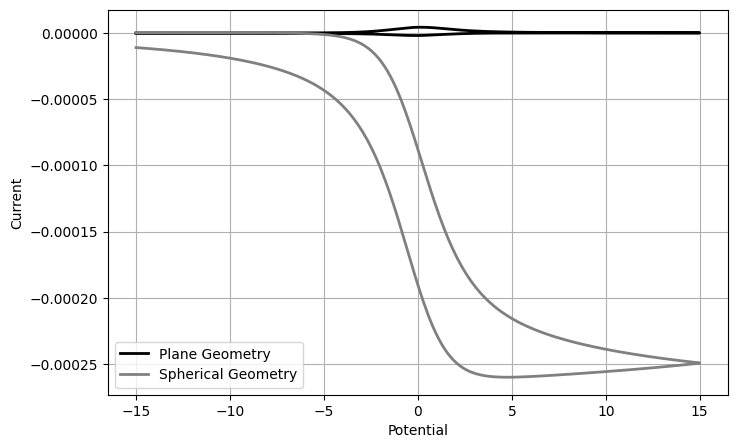

In [118]:
plt.figure(figsize=(8, 5))
plt.plot(epsilon, I , '-',color='black', linewidth=2 , label = 'Plane Geometry')
plt.plot(epsilon, Ie , '-',color='gray', linewidth=2 ,label = 'Spherical Geometry')
plt.xlabel("Potential")
plt.ylabel("Current")
plt.grid(True)

plt.legend()
plt.show()